In [1]:
from surgery_utils import surgery_preprocess, split, get_scores, plot_scores
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score,train_test_split,RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, f1_score, average_precision_score, roc_curve, auc

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

from hyperopt import Trials, fmin, tpe, anneal, space_eval, hp
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [90]:
surgery = surgery_preprocess(split=False)
surgery.drop(columns='_DGN5',inplace=True)
ros = RandomOverSampler()
kf = StratifiedKFold(n_splits=5,shuffle=True)
surgery.columns

Index(['FVC', 'FEV1', 'Performance', 'Pain', 'Haemoptysis', 'Dyspnoea',
       'Cough', 'Weakness', 'Tumor_size', 'Type2_diabetes', 'Smoking', 'Age',
       'Risk1Yr', 'FEV1/FVC', 'FEV1_deficit', 'FVC_deficit',
       'FEV1/FVC_deficit', 'FEV1^2', 'FVC^2', 'Age*FVC', 'Age*FEV1',
       'FVC*FEV1', 'FVC^2*FEV1', 'FVC*FEV1^2', '_DGN2', '_DGN3', '_DGN4'],
      dtype='object')

Our baseline model will be a logistic regression without any hyperparameter tuning, engineered features, or upsampling

In [5]:
lr_baseline = LogisticRegression()
engineered_feats = ['FEV1/FVC', 'FEV1_deficit', 'FVC_deficit',
       'FEV1/FVC_deficit', 'FEV1^2', 'FVC^2', 'Age*FVC', 'Age*FEV1',
       'FVC*FEV1', 'FVC^2*FEV1', 'FVC*FEV1^2']
scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']
baseline_scores = {}
train_idx = []
test_idx = []
for s in scores:
    baseline_scores['train_'+s] = np.zeros(30)
    baseline_scores['test_'+s] = np.zeros(30)
for i in range(30):
    X_train, X_test, y_train, y_test = split(surgery, drop_cols=engineered_feats)
    train_idx.append(X_train.index)
    test_idx.append(X_test.index)
    model_scores = get_scores(lr_baseline, X_train, X_test, 
                             y_train, y_test, scores)
    for s in scores:
        baseline_scores['train_'+s][i] = model_scores['train_'+s]
        baseline_scores['test_'+s][i] = model_scores['test_'+s]
for s in scores:
    print(f'Mean train_{s}: {baseline_scores["train_"+s].mean()}')
    print(f'Mean test_{s}: {baseline_scores["test_"+s].mean()}')

Mean train_roc_auc_score: 0.7554728234728234
Mean test_roc_auc_score: 0.674653405666064
Mean train_recall_score: 0.02727272727272727
Mean test_recall_score: 0.0047619047619047615
Mean train_accuracy_score: 0.849009009009009
Mean test_accuracy_score: 0.8390681003584227
Mean train_average_precision_score: 0.3405762821925052
Mean test_average_precision_score: 0.28086052241673404


With upsampling:

In [232]:
upsamp_scores = {}
for s in scores:
    upsamp_scores['train_'+s] = np.zeros(30)
    upsamp_scores['test_'+s] = np.zeros(30)

for i in range(30):
    upsamp_pipe = Pipeline([('upsample',RandomOverSampler(sampling_strategy=1.0)),
                            ('model', LogisticRegression(max_iter=2000))])
    X_train, X_test, y_train, y_test = split(surgery, drop_cols=engineered_feats,
                                             idx=train_idx[i])
    model_scores = get_scores(upsamp_pipe, X_train, X_test, 
                             y_train, y_test, scores)   
    for s in scores:
        upsamp_scores['train_'+s][i] = model_scores['train_'+s]
        upsamp_scores['test_'+s][i] = model_scores['test_'+s]
for s in scores:
    print(f'Mean train_{s}: {upsamp_scores["train_"+s].mean()}')
    print(f'Mean test_{s}: {upsamp_scores["test_"+s].mean()}')

Mean train_roc_auc_score: 0.7586108706108707
Mean test_roc_auc_score: 0.6791139240506328
Mean train_recall_score: 0.6739393939393942
Mean test_recall_score: 0.5547619047619048
Mean train_accuracy_score: 0.7017117117117118
Mean test_accuracy_score: 0.6469534050179213
Mean train_average_precision_score: 0.32700267873700695
Mean test_average_precision_score: 0.283877648055979


Upsampling helps improve recall and AUPRC (measured with average_precision), but it hurts accuracy. Given the nature of the problem, a few false positives is better than many false negatives. Let's try different values of upsampling to see how the scores change:

In [15]:
upsamp_fractions = np.linspace(0.2,1.0,9)
upsamp_scores_2 = {}
for f in upsamp_fractions:
    upsamp_scores_2[f] = {}
    for s in scores:
        upsamp_scores_2[f]['train_'+s] = np.zeros(30)
        upsamp_scores_2[f]['test_'+s] = np.zeros(30)

for f in upsamp_fractions:
    for i in range(30):
        upsamp_pipe = Pipeline([('upsample',RandomOverSampler(sampling_strategy=f)),
                                ('model', LogisticRegression(max_iter=2000))])
        X_train, X_test, y_train, y_test = split(surgery, drop_cols=engineered_feats,
                                                 idx=train_idx[i])
        model_scores = get_scores(upsamp_pipe, X_train, X_test, 
                                 y_train, y_test, scores)   
        for s in scores:
            upsamp_scores_2[f]['train_'+s][i] = model_scores['train_'+s]
            upsamp_scores_2[f]['test_'+s][i] = model_scores['test_'+s]

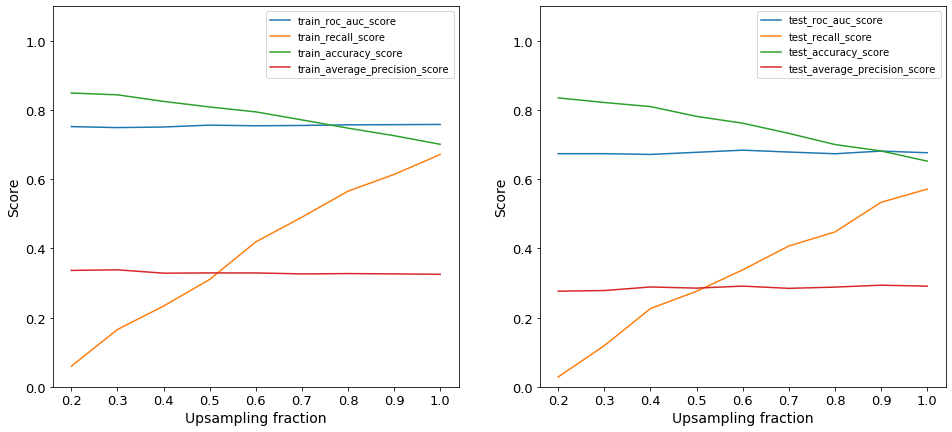

In [16]:
fig, ax = plt.subplots(1,2, figsize=(16,7))
for s in scores:
    train_line = np.zeros(9)
    test_line = np.zeros(9)
    for i in range(9):
        train_line[i] = upsamp_scores_2[upsamp_fractions[i]]['train_'+s].mean()
        test_line[i] = upsamp_scores_2[upsamp_fractions[i]]['test_'+s].mean()
    ax[0].plot(upsamp_fractions, train_line, label='train_'+s)
    ax[1].plot(upsamp_fractions, test_line, label='test_'+s)
ax[0].legend(loc='upper right')
ax[0].set_ylim(0,1.1)
ax[0].set_xlabel('Upsampling fraction',size=14)
ax[0].set_ylabel('Score',size=14)
ax[0].tick_params(labelsize=13)
ax[1].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
ax[1].set_xlabel('Upsampling fraction',size=14)
ax[1].set_ylabel('Score',size=14)
ax[1].tick_params(labelsize=13)

A Logistic Regression model after feature engineering, but without upsampling or tuning:

In [18]:
lr_engineering = LogisticRegression()
engineering_scores = {}
for s in scores:
    engineering_scores['train_'+s] = np.zeros(30)
    engineering_scores['test_'+s] = np.zeros(30)
for i in range(30):
    X_train, X_test, y_train, y_test = split(surgery, idx=train_idx[i])
    model_scores = get_scores(lr_engineering, X_train, X_test, 
                             y_train, y_test, scores)   
    for s in scores:
        engineering_scores['train_'+s][i] = model_scores['train_'+s]
        engineering_scores['test_'+s][i] = model_scores['test_'+s]
for s in scores:
    print(f'Mean train_{s}: {engineering_scores["train_"+s].mean()}')
    print(f'Mean test_{s}: {engineering_scores["test_"+s].mean()}')

Mean train_roc_auc_score: 0.7676325156325156
Mean test_roc_auc_score: 0.6683845690174803
Mean train_recall_score: 0.034545454545454546
Mean test_recall_score: 0.019047619047619042
Mean train_accuracy_score: 0.8491891891891892
Mean test_accuracy_score: 0.8405017921146952
Mean train_average_precision_score: 0.35448387888498145
Mean test_average_precision_score: 0.28646688971379225


And with upsampling, too:

In [19]:
eng_up_scores = {}
for s in scores:
    eng_up_scores['train_'+s] = np.zeros(30)
    eng_up_scores['test_'+s] = np.zeros(30)
for i in range(30):
    lr_engineering = LogisticRegression()
    lr_pipe = Pipeline([('upsampling',ros),('model',lr_engineering)])
    X_train, X_test, y_train, y_test = split(surgery, idx=train_idx[i])
    model_scores = get_scores(lr_pipe, X_train, X_test, 
                             y_train, y_test, scores)   
    for s in scores:
        eng_up_scores['train_'+s][i] = model_scores['train_'+s]
        eng_up_scores['test_'+s][i] = model_scores['test_'+s]
for s in scores:
    print(f'Mean train_{s}: {eng_up_scores["train_"+s].mean()}')
    print(f'Mean test_{s}: {eng_up_scores["test_"+s].mean()}')

Mean train_roc_auc_score: 0.7717883597883597
Mean test_roc_auc_score: 0.6687462326702834
Mean train_recall_score: 0.6963636363636365
Mean test_recall_score: 0.5738095238095239
Mean train_accuracy_score: 0.7055855855855857
Mean test_accuracy_score: 0.6512544802867384
Mean train_average_precision_score: 0.33712464012318083
Mean test_average_precision_score: 0.30343291280802537


Most of our testing metrics have gone down, while all training metrics have gone up. This indicates some overfitting. Let's try dropping several subsets to see which works best:

In [25]:
to_drop = {'set_1': ['FVC*FEV1','FVC^2*FEV1','FVC*FEV1^2'],
           'set_2': ['FVC_deficit','FEV1_deficit','FEV1/FVC_deficit'],
           'set_3': ['FVC*FEV1','FVC^2*FEV1','FVC*FEV1^2','FVC_deficit','FEV1_deficit',
            'FEV1/FVC_deficit'],
           'set_4': ['FVC*FEV1','FVC^2','FEV1^2'],
           'set_5': ['FVC*FEV1','FVC^2','FEV1^2','FVC^2*FEV1','FVC*FEV1^2'],
           'set_6': ['Pain', 'Dyspnoea', 'Haemoptysis', 'Weakness', 'Performance']}
to_drop['set_7'] = to_drop['set_6']+to_drop['set_1']
to_drop['set_8'] = to_drop['set_6']+to_drop['set_2']
to_drop['set_9'] = []

m = 30
selection_results = {}
for k in to_drop.keys():
    selection_results[k] = {}
    for s in scores:
        selection_results[k]['train_'+s] = np.zeros(m)
        selection_results[k]['test_'+s] = np.zeros(m)
    
for i in range(m):
    X_train, X_test, y_train, y_test = split(surgery, idx=train_idx[i])
    lr = LogisticRegression(max_iter=2000)
    pipe = Pipeline([('upsample',RandomOverSampler(sampling_strategy=1.0)),
                            ('model', lr)])
    for k in to_drop.keys():
        model_scores = get_scores(lr_engineering, X_train.drop(columns=to_drop[k]),
                                            X_test.drop(columns=to_drop[k]), 
                                 y_train, y_test, scores)   
        for s in scores:
            selection_results[k]['train_'+s][i] = model_scores['train_'+s]
            selection_results[k]['test_'+s][i] = model_scores['test_'+s]
for k in selection_results.keys():
    print(f'{k} mean scores:')
    for s in scores:
        #print(f'validation_{s}: {selection_results[k]["validation_"+s].mean()}')
        print(f'test_{s}: {selection_results[k]["test_"+s].mean()}')
    print('')

set_1 mean scores:
test_roc_auc_score: 0.6718806509945751
test_recall_score: 0.019047619047619042
test_accuracy_score: 0.8405017921146952
test_average_precision_score: 0.28828832785519837

set_2 mean scores:
test_roc_auc_score: 0.6681735985533455
test_recall_score: 0.016666666666666663
test_accuracy_score: 0.8412186379928314
test_average_precision_score: 0.2835896837651644

set_3 mean scores:
test_roc_auc_score: 0.6719409282700421
test_recall_score: 0.016666666666666663
test_accuracy_score: 0.8415770609318994
test_average_precision_score: 0.2865752974135142

set_4 mean scores:
test_roc_auc_score: 0.6688969258589511
test_recall_score: 0.019047619047619042
test_accuracy_score: 0.840143369175627
test_average_precision_score: 0.28548634710382426

set_5 mean scores:
test_roc_auc_score: 0.6737793851717904
test_recall_score: 0.014285714285714284
test_accuracy_score: 0.8390681003584227
test_average_precision_score: 0.29036774750881006

set_6 mean scores:
test_roc_auc_score: 0.6715491259795058


Prior analyses showed that the results of our models are heavily dependent on the intial train/test split. We will therefore run multiple trials with this split as the start point and average the results.

In [27]:
# Function to plot ROC curves of one model, from k different train/test splits
# model_name = Name of the model
# roc_dict = from build_model, return_roc=True
# nruns = from build_model, k
# colors = ['color1','color2',...,'colork']
def plot_auroc(model_name,roc_dict,nruns,colors=None):
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    if not colors:
        colors = np.random.random(size=(nruns,3))        
    axs[0].set_title(model_name.title()+' Train ROC Curves')
    axs[1].set_title(model_name.title()+' Test ROC Curves')
    for i in range(nruns):
        axs[0].plot(roc_dict['run'+str(i)+'_train_fpr'], roc_dict['run'+str(i)+'_train_tpr'], c=colors[i], 
                 label = 'Run '+str(i)+' AUC = %0.2f' % auc(roc_dict['run'+str(i)+'_train_fpr'], roc_dict['run'+str(i)+'_train_tpr']))
        axs[1].plot(roc_dict['run'+str(i)+'_test_fpr'], roc_dict['run'+str(i)+'_test_tpr'], c=colors[i], 
                 label = 'Run '+str(i)+' AUC = %0.2f' % auc(roc_dict['run'+str(i)+'_test_fpr'], roc_dict['run'+str(i)+'_test_tpr']))
    for ax in axs.flat:
        ax.legend(loc = 'lower right')
        ax.plot([0, 1], [0, 1],'r--')
        ax.set_xlim([0, 1.0])
        ax.set_ylim([0, 1.01])
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
    plt.show()

In [122]:
run = np.argmin(np.abs(np.array(lr_scores['test_roc_auc_score'])-np.mean(lr_scores['test_roc_auc_score'])))
run

4

In [141]:
# Function to plot the ROC curves of every model after averaging
# model_names = Names of the model in order
# roc_dicts = list of roc_dicts in order
# nruns = k's in order
# colors = list of colors, optional
def plot_aurocs(model_names,roc_dicts,scores_dicts,nruns_list,colors=None):
    n = len(model_names)
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    if not colors:
        colors = np.random.random(size=(n,3))        
    axs[0].set_title('Mean Train ROC Curves')
    axs[1].set_title('Mean Test ROC Curves')
    # Each run plots for one model
    for i in range(n):
        # Find argmin of absolute difference from mean in scores
        run = np.argmin(np.abs(np.array(scores_dicts[i]['test_roc_auc_score'])-np.mean(scores_dicts[i]['test_roc_auc_score'])))
        fprs_train = roc_dicts[i]['run'+str(run)+'_train_fpr']
        tprs_train = roc_dicts[i]['run'+str(run)+'_train_tpr']
        fprs_test = roc_dicts[i]['run'+str(run)+'_test_fpr']
        tprs_test = roc_dicts[i]['run'+str(run)+'_test_tpr']

            
        axs[0].plot(fprs_train, tprs_train, c=colors[i], 
                 label = model_names[i].title() + ' Train AUC = %0.2f' % auc(fprs_train,tprs_train))
        axs[1].plot(fprs_test, tprs_test, c=colors[i], 
                 label = model_names[i].title() + ' Test AUC = %0.2f' % auc(fprs_test,tprs_test))
    for ax in axs.flat:
        ax.legend(loc = 'lower right')
        ax.plot([0, 1], [0, 1],'r--')
        ax.set_xlim([0, 1.0])
        ax.set_ylim([0, 1.01])
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
    plt.show()  

In [ ]:
def build_model(model, params, obj, scores, data, k=6, evals=40, scoring='roc_auc',
                drop=[], return_idx=False, return_roc=False, **model_args):
    scores_dict={}
    param_list=[]
    if return_idx:
        idx_list = []
    if return_roc:
        roc_dict = {}
        
    for s in scores:
        scores_dict['train_'+s] = np.zeros(k)
        scores_dict['test_'+s] = np.zeros(k)
    for i in range(k):
        X_train, X_test, y_train, y_test = split(data, drop_cols=drop)
        mod = model(**model_args)
        pipe = Pipeline([('upsample',ros),('model',mod)])
        trials = Trials()
        # Partial make its own callable function. When you call partial() you supply
        # a function with n args and supply k of them. Then, when you call the function
        # that partial creates, you supply the remaining n-k. These n-k serve as the
        # FIRST arguments to the function of which you made a partial
        fmin_func = partial(obj, pipe=pipe, train_X=X_train, train_y=y_train,
                            scoring=scoring)
        best = fmin(fn=fmin_func, 
                    space=params, algo=anneal.suggest, max_evals=evals,
                    trials=trials)
        best_params = space_eval(params,best)
        
        pipe.fit(X_train,y_train)
        pipe.set_params(**best_params)
        model_scores = get_scores(pipe, X_train, X_test, y_train, y_test,
                                  scores)
        for s in scores:
            scores_dict['train_'+s][i] = model_scores['train_'+s]
            scores_dict['test_'+s][i] = model_scores['test_'+s]
        param_list.append(best_params)
        if return_idx:
            idx_list.append(X_train.index)
        if return_roc:
            probs_v = pipe.predict_proba(X_train)[:,1]
            probs_t = pipe.predict_proba(X_test)[:,1]   
            fpr_v, tpr_v, threshold_v = roc_curve(y_train, probs_v)
            fpr_t, tpr_t, threshold_t = roc_curve(y_test, probs_t)
            roc_dict['run'+str(i)+'_train_fpr'] = fpr_v
            roc_dict['run'+str(i)+'_train_tpr'] = tpr_v
            roc_dict['run'+str(i)+'_test_fpr'] = fpr_t            
            roc_dict['run'+str(i)+'_test_tpr'] = tpr_t
    if return_idx:
        if return_roc:
            return scores_dict, param_list, idx_list, roc_dict
        return scores_dict, param_list, idx_list
    if return_roc:
        scores_dict, param_list, roc_dict
    return scores_dict, param_list

In [250]:
def lr_objective(params, pipe, train_X, train_y, scoring='roc_auc'):
    pipe.set_params(**params)
    score = cross_val_score(pipe, train_X, train_y, cv=kf, 
                            scoring=scoring)
    return 1-score.mean()

scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']

lr_space = {'model__C': hp.uniform('model__C', 0,500)}
lr_args = {'max_iter': 2000,'C': 1.0000001}

lr_scores, lr_params, lr_idx, lr_roc = build_model(LogisticRegression, lr_space,
                                                   lr_objective, scores, surgery,
                                                   drop=to_drop['set_6'],
                                                   return_idx=True, evals=30,
                                                  return_roc=True, **lr_args)

100%|███████████████████████████████████████████████| 30/30 [00:29<00:00,  1.01trial/s, best loss: 0.36046176046176037]


In [251]:
for s in scores:
    print(f'Mean train_{s}: {lr_scores["train_"+s].mean()}')
    print(f'Mean test_{s}: {lr_scores["test_"+s].mean()}')

Mean train_roc_auc_score: 0.7526214526214526
Mean test_roc_auc_score: 0.6738999397227244
Mean train_recall_score: 0.7090909090909091
Mean test_recall_score: 0.5476190476190476
Mean train_accuracy_score: 0.6932432432432433
Mean test_accuracy_score: 0.6845878136200718
Mean train_average_precision_score: 0.3581532367676425
Mean test_average_precision_score: 0.313626121959139


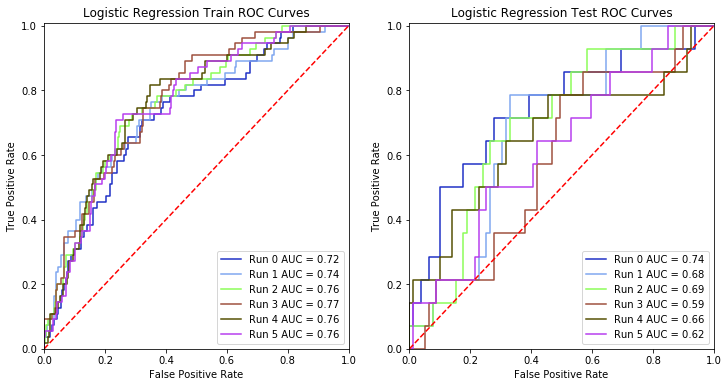

In [60]:
plot_auroc('logistic regression',lr_roc,6)

In [164]:
def sv_objective(params, pipe, train_X, train_y, scoring='roc_auc'):
    pipe.set_params(**params)
    score = cross_val_score(pipe, train_X, train_y, cv=kf, scoring=scoring)
    return 1-score.mean()

scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']

sv_space = {'model__C': hp.uniform('model__C', 0,300)}
sv_args = {'kernel': 'linear', 'probability': True}

sv_scores, sv_params, sv_idx, sv_roc = build_model(SVC, sv_space,
                                           sv_objective, scores, surgery,
                                           drop=to_drop['set_8'], k=4, evals=20,
                                           return_idx=True, return_roc=True, **sv_args)

100%|████████████████████████████████████████████████| 20/20 [09:00<00:00, 27.03s/trial, best loss: 0.3134199134199134]


In [167]:
for s in scores:
    print(f'Mean train_{s}: {sv_scores["train_"+s].mean()}')
    print(f'Mean test_{s}: {sv_scores["test_"+s].mean()}')

Mean train_roc_auc_score: 0.7575252525252526
Mean test_roc_auc_score: 0.5935804701627487
Mean train_recall_score: 0.6636363636363637
Mean test_recall_score: 0.41071428571428575
Mean train_accuracy_score: 0.7250000000000001
Mean test_accuracy_score: 0.6236559139784945
Mean train_average_precision_score: 0.36197816413193934
Mean test_average_precision_score: 0.2524898910791151


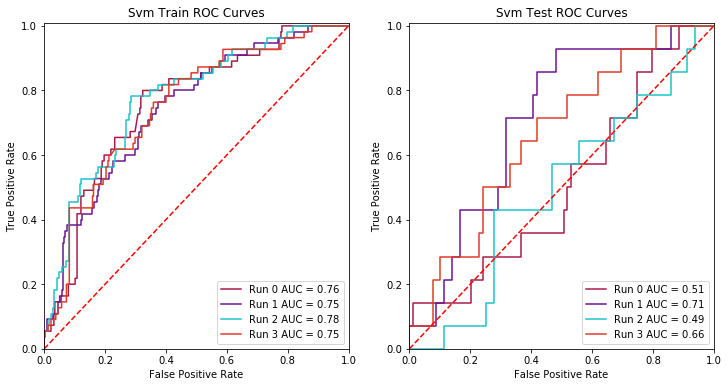

In [165]:
plot_auroc('SVM',sv_roc,4)

In [99]:
import lightgbm as lgb

def lg_objective(params, pipe, train_X, train_y, scoring):
    pipe.set_params(**params)
    score = cross_val_score(pipe, train_X, train_y, cv=kf, scoring=scoring).mean()
    return 1-score

lg_space = {'model__n_estimators': hp.choice('model__n_estimators', range(70,80)),
             'model__learning_rate': hp.uniform('model__learning_rate',0.1,0.2),
             'model__max_depth': hp.choice('model__max_depth', range(6,12)),
             'model__bagging_fraction ': hp.uniform('model__subsample', 0.7, 1.0),
             'model__lambda_l2': hp.uniform('model__lambda_l2', 2.0,10.0),
             'model__num_leaves': hp.choice('model__num_leaves',range(10,40)),
             'model__feature_fraction': hp.uniform('model__feature_fraction',0.5,0.8),
            'model__max_bin': hp.choice('model__max_bin', range(30,60)),
            'model__min_data_in_leaf': hp.choice('model__min_data_in_leaf',range(15,30))}

cat_feats = list(range(2,11))+list(range(23,26))

lg_args = {'metric': 'binary_logloss', 'categorical_features': cat_feats,
           'objective_type': 'binary'}
scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']


lg_scores, lg_params, lg_idx, lg_roc = build_model(LGBMClassifier, lg_space, lg_objective,
                                       scores, surgery, drop=[], evals=40, k=4, 
                                       return_idx=True, return_roc=True, **lg_args)

100%|███████████████████████████████████████████████| 40/40 [00:16<00:00,  2.40trial/s, best loss: 0.38470418470418477]


In [139]:
for s in scores:
    print(f'Mean train_{s}: {lg_scores["train_"+s].mean()}')
    print(f'Mean test_{s}: {lg_scores["test_"+s].mean()}')

Mean train_roc_auc_score: 0.9999567099567099
Mean test_roc_auc_score: 0.5899638336347197
Mean train_recall_score: 1.0
Mean test_recall_score: 0.14285714285714285
Mean train_accuracy_score: 0.9939189189189188
Mean test_accuracy_score: 0.8037634408602151
Mean train_average_precision_score: 0.9997648902821317
Mean test_average_precision_score: 0.2233508220188077


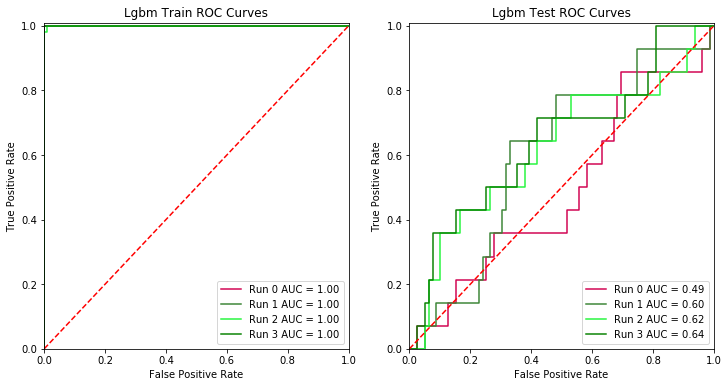

In [140]:
plot_auroc('LGBM',lg_roc,4)

In [155]:
def rf_objective(params, pipe, train_X, train_y, scoring='roc_auc'):
    pipe.set_params(**params)
    score = cross_val_score(pipe, train_X, train_y, cv=kf, scoring=scoring).mean()
    return 1-score

rf_space = {'model__n_estimators': hp.choice('model__n_estimators', range(70,200)),
             'model__min_samples_leaf': hp.choice('model__min_samples_leaf',range(1,21)),
             'model__min_samples_split': hp.choice('model__min_samples_split',range(2,31)),
             'model__max_features': hp.uniform('model__max_features', 0.5, 0.9),
             'model__max_depth': hp.choice('model__max_depth', range(3,26))}

scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']


rf_scores, rf_params, rf_idx, rf_roc = build_model(RandomForestClassifier, rf_space, rf_objective,
                                       scores, surgery, drop=to_drop['set_8'], k=4,
                                       return_idx=True, return_roc=True, scoring='roc_auc')

100%|████████████████████████████████████████████████| 40/40 [01:09<00:00,  1.75s/trial, best loss: 0.3587301587301587]


In [156]:
for s in scores:
    print(f'Mean train_{s}: {rf_scores["train_"+s].mean()}')
    print(f'Mean test_{s}: {rf_scores["test_"+s].mean()}')

Mean train_roc_auc_score: 0.9636796536796537
Mean test_roc_auc_score: 0.5718806509945751
Mean train_recall_score: 0.9090909090909091
Mean test_recall_score: 0.17857142857142855
Mean train_accuracy_score: 0.9263513513513515
Mean test_accuracy_score: 0.7419354838709677
Mean train_average_precision_score: 0.888889521845956
Mean test_average_precision_score: 0.23409008250216362


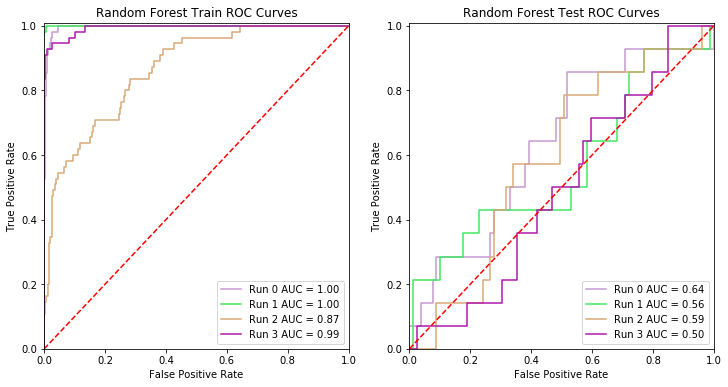

In [157]:
plot_auroc('Random Forest',rf_roc,4)

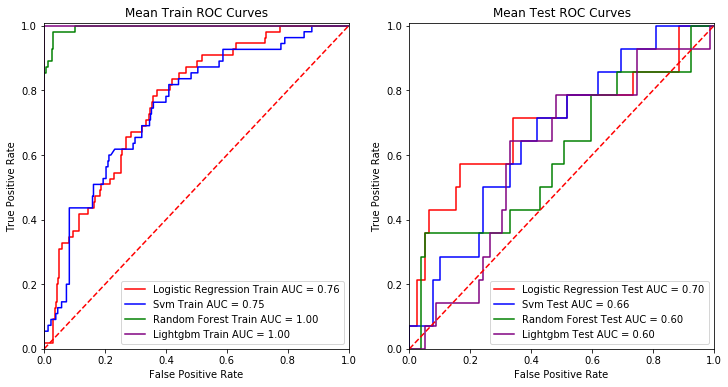

In [242]:
plot_aurocs(['Logistic Regression','SVM','Random Forest','LightGBM'],
             [lr_roc,sv_roc,rf_roc_backup,lg_roc],
             [lr_scores,sv_scores,rf_scores_backup,lg_scores],[3,3,3],
             colors=['red','blue','green','purple'])

In [243]:
#rf_roc_backup = rf_roc.copy()
#rf_scores_backup = rf_scores.copy()
#rf_params_backup = rf_params.copy()

# With set 2
#lr_roc_backup = lr_roc.copy()
#lr_scores_backup = lr_scores.copy()
#lr_params_backup = lr_params.copy()

## Model explainability

For this use case, the black box nature of machine learning models limits their practicality in informing decision-making. A doctor may know that a patient is at risk, but they also need to know *why* in order to prepare a treatment plan. Feature importance, being a global metric, does not suffice for this. We need to understand local importance; thus, model explainability through SHAP and LIME.

For the following demonstration, we will use the best-performing model. By AUC there is a tie, so we will use recall as a tie-breaker and choose Logistic Regression.

### SHAP

In [175]:
# Code will for now be for a logistic regression. We'll update it with the best model later
# Use params and X_train of an average trial
import shap
lr_pipe = Pipeline([('upsample',ros),('model',LogisticRegression(max_iter=2000))])
run = np.argmin(np.abs(np.array(lr_scores['test_roc_auc_score'])-np.mean(lr_scores['test_roc_auc_score'])))
lr_pipe.set_params(**lr_params[run])
X_train, X_test, y_train, y_test = split(surgery, idx=lr_idx[run], 
                                         drop_cols=to_drop['set_7'])
lr_pipe.fit(X_train, y_train)

lr_explainer = shap.KernelExplainer(lr_pipe.predict_proba, X_test)
lr_shapvals = lr_explainer.shap_values(X_test)

shap.initjs()

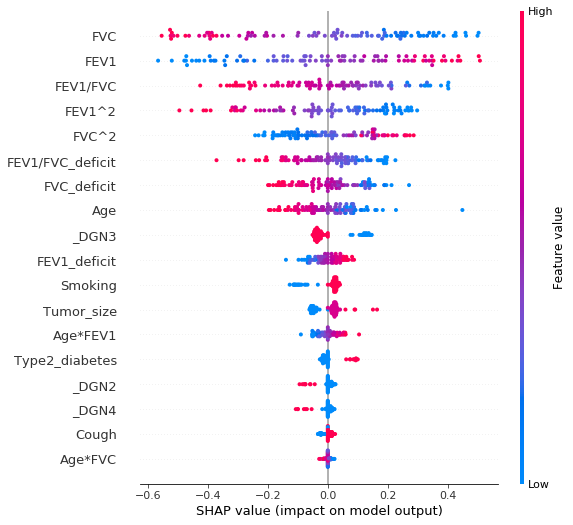

In [176]:
# The summary plot shows the SHAP value for each feature and for each
# instance, colored by magnitude of the feature
shap.summary_plot(lr_shapvals[1], X_test)

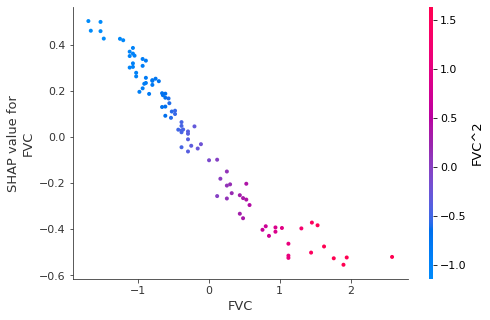

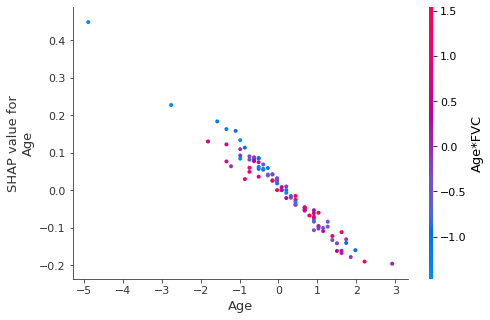

In [194]:
# The dependence plot shows how a single feature's SHAP value
# depends on its magnitude. It is colored by whichever other
# feature the chosen one interacts most with

shap.dependence_plot('FVC',lr_shapvals[1], X_test)
shap.dependence_plot('Age',lr_shapvals[1], X_test)

The force plot is our local explainability. Red wedges indicatethat that feature made our prediction more likely to be positive. Blue, the opposite. Wedge width corresponds to that feature's Shapley value. The middle value (bold black text) is what the model predicts; the model then transforms that prediction into a \[0,1\] probability space. Here, if that value is above 0.42660686, the model predicts a positive.

In [186]:
np.where(lr_pipe.predict(X_test)==0)
#np.where(lr_pipe.predict(X_test)==1) # Let's find a true positive and a true negative

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 17, 19,
        20, 22, 23, 24, 26, 29, 32, 33, 34, 35, 36, 38, 39, 41, 43, 45, 47,
        48, 49, 50, 51, 52, 53, 55, 57, 59, 61, 62, 63, 67, 70, 71, 79, 80,
        81, 83, 84, 85, 86, 88, 89, 91, 92], dtype=int64),)

In [184]:
np.where(y_test.values==1)

(array([ 1, 12, 16, 23, 30, 31, 37, 42, 47, 50, 57, 69, 78, 90],
       dtype=int64),)

In [209]:
!jt -t chesterish

In [187]:
# True negative
shap_values_0 = lr_explainer.shap_values(X_test.iloc[0,:], nsamples=1000)
shap.force_plot(lr_explainer.expected_value[1], shap_values_0[1], X_test.iloc[0,:])

In [188]:
shap_values_1 = lr_explainer.shap_values(X_test.iloc[12,:], nsamples=1000)
shap.force_plot(lr_explainer.expected_value[1], shap_values_1[1], X_test.iloc[1,:])

Note how the most important feature for the negative example was FVC^2, but the most important for the positive example was FVC\*FEV1. This shows how local feature importance can be different from global feature importance.

Finally, the global force plot. Each point on the x-axis is essentially the above plot, but flipped vertical

In [189]:
shap.force_plot(lr_explainer.expected_value[1], lr_shapvals[1], feature_names=X_test.columns)

### LIME

In [190]:
# Use X_train, X_test, y_train, y_test from SHAP cells above

import lime
from lime import lime_tabular

# Perform LIME
lime_explainer = lime_tabular.LimeTabularExplainer(X_train.to_numpy(), 
                                                   mode='classification', 
                                                   feature_names = X_train.columns)

#### Positive example:

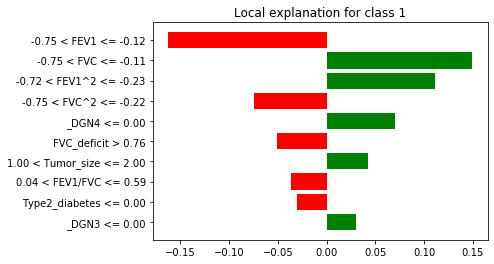

In [191]:
# Show the results
lime_exp = lime_explainer.explain_instance(X_test.iloc[12], lr_pipe.predict_proba)
lime_exp.show_in_notebook(show_table=True, show_all=False)
lime_exp.as_pyplot_figure();

#### Negative example:

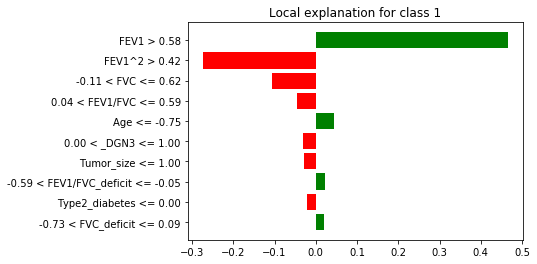

In [192]:
lime_exp = lime_explainer.explain_instance(X_test.iloc[0], lr_pipe.predict_proba)
lime_exp.show_in_notebook(show_table=True, show_all=False)
lime_exp.as_pyplot_figure();

In [207]:
def get_importances(pipe, train_X, train_y, n):
    importances_avg = np.zeros(len(train_X.columns))
    for i in range(n):
        pipe.fit(train_X, train_y)
        importances_avg += np.array(pipe.steps[1][1].feature_importances_)
        
    importances_avg /= n

    importance_inds = importances_avg.argsort()
    plt.figure(figsize = (12,8))
    plt.barh(train_X.columns[importance_inds],importances_avg[importance_inds])
    plt.xlabel('Relative importance', size=13)
    plt.ylabel('Feature', size=13)
    plt.xticks(rotation=90)
    plt.show()
    
    return importances_avg

In [204]:
rf_params[run_rf]

{'model__max_depth': 20,
 'model__max_features': 0.7400952965796683,
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 15,
 'model__n_estimators': 155}

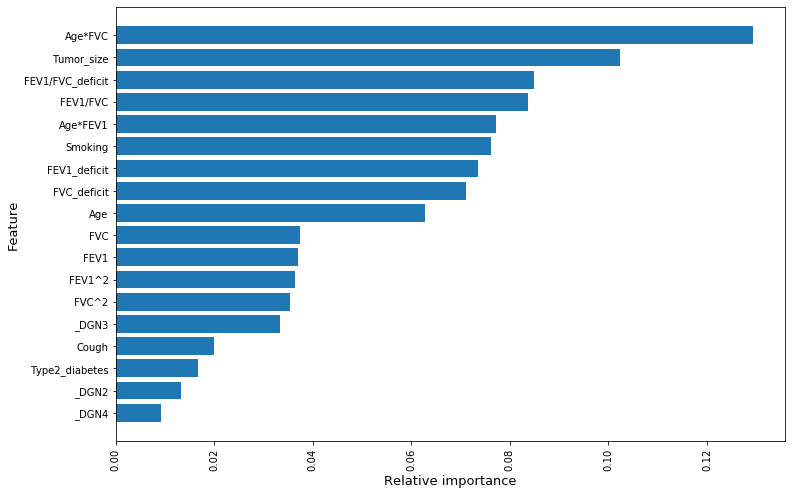

In [208]:
import matplotlib.pyplot as plt
rf_pipe = Pipeline([('upsample',ros),('model',RandomForestClassifier())])
run_rf = np.argmin(np.abs(np.array(rf_scores['test_roc_auc_score'])-np.mean(rf_scores['test_roc_auc_score'])))
rf_pipe.set_params(**rf_params[run_rf])
importances_avg = get_importances(rf_pipe, X_train, y_train, 5)


In [216]:
run2 = np.argmin(np.abs(np.array(sv_scores['test_roc_auc_score'])-np.mean(sv_scores['test_roc_auc_score'])))
print(sv_params[run2])

{'model__C': 201.531442823442}
